In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel # <--- Đổi sang RoBERTa
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import json
import os

# Cấu hình thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. DATASET VỚI CLASS WEIGHT ---
class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=128, is_train=False): 
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['clean_text', 'stars']).reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_train = is_train
        
        # Tự động tính toán trọng số (chỉ cho tập Train)
        self.weights_map = {}
        if self.is_train:
            self.weights_map = self.calculate_weights()
            print(f"--> Class Weights map: {self.weights_map}")

    def calculate_weights(self):
        counts = self.df['stars'].value_counts().to_dict()
        total_samples = len(self.df)
        num_classes = len(counts)
        # Công thức nghịch đảo tần suất
        weights = {score: total_samples / (num_classes * count) for score, count in counts.items()}
        return weights

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.loc[index, 'clean_text'])
        score = float(self.df.loc[index, 'stars'])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        # Lấy trọng số (Mặc định 1.0 nếu là Test/Val)
        sample_weight = self.weights_map.get(score, 1.0) if self.is_train else 1.0

        return { 
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(score, dtype=torch.float),
            'weight': torch.tensor(sample_weight, dtype=torch.float)
        }

# --- 2. KHỞI TẠO DATALOADER (Dùng RobertaTokenizer) ---
tokenizer = RobertaTokenizer.from_pretrained('roberta-base') 

train_dataset = ReviewDataset('trains.csv', tokenizer, is_train=True) 
test_dataset = ReviewDataset('test.csv', tokenizer, is_train=False)
val_dataset = ReviewDataset('val.csv', tokenizer, is_train=False) 

# Batch size 16 hoặc 32 tuỳ VRAM
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

# --- 3. CLASS EARLY STOPPING ---
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose: print(f'EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

c:\activities\DLProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
--> Class Weights map: {5: 0.44982311700006433, 4: 0.7938475509393269, 3: 1.7657871480873628, 1: 1.8255955100176207, 2: 2.4805888090804293}


In [2]:
class RoBERTaRegressor_head(nn.Module):
    def __init__(self, head_type='simple'):
        super(RoBERTaRegressor_head, self).__init__()
        
        # Load RoBERTa Base
        self.roberta = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
        
        # Đóng băng RoBERTa
        for param in self.roberta.parameters():
            param.requires_grad = False
            
        self.head_type = head_type
        
        # RoBERTa base cũng có hidden size = 768 giống BERT
        # Input dim = 768 * 4 layers = 3072
        input_dim = 768 * 4 
        
        self.ln = nn.LayerNorm(input_dim) # Chuẩn hóa đầu vào lớn

        # Định nghĩa các Head
        if head_type == 'simple':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 1)
            )
            
        elif head_type == 'medium':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.LayerNorm(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 1)
            )
            
        elif head_type == 'complex':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 1024),
                nn.LayerNorm(1024),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(1024, 256),
                nn.LayerNorm(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 1)
            )
            
        elif head_type == 'bounded':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid() 
            )

    def forward(self, input_ids, attention_mask):
        # Forward qua RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # Lấy hidden states
        hidden_states = outputs.hidden_states
        
        # Lấy token <s> (vị trí 0) từ 4 lớp cuối: -1, -2, -3, -4
        # RoBERTa dùng <s> thay vì [CLS] nhưng vẫn ở vị trí index 0
        cls_embeddings = [hidden_states[i][:, 0, :] for i in [-1, -2, -3, -4]]
        
        # Nối lại: (Batch, 3072)
        embedding = torch.cat(cls_embeddings, dim=1)

        embedding = self.ln(embedding) 
        out = self.regressor(embedding)

        if self.head_type == 'bounded':
            # Scale sigmoid (0-1) về khoảng (1-5)
            out = 1.0 + (out * 4.0)

        return out

# Hàm Evaluate
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = [] 
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device) 
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask) 
            
            predictions.extend(outputs.squeeze().tolist())
            real_values.extend(targets.tolist())
            
    mse = mean_squared_error(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions)
    r2 = r2_score(real_values, predictions)
    
    return mse, mae, r2, real_values, predictions

In [3]:
# --- CẤU HÌNH ---
head_types = ['simple', 'medium', 'complex', 'bounded']
roberta_results = {}
history = {}
EPOCHS = 20
PATIENCE = 3

print(f"{'='*10} CHẠY THÍ NGHIỆM TRÊN ROBERTA-BASE {'='*10}")

for head in head_types:
    print(f"\n>>> Đang train RoBERTa Head: {head.upper()}...")
    
    # Khởi tạo model RoBERTa
    model = RoBERTaRegressor_head(head_type=head).to(device)
    
    # Loss không giảm (reduction='none') để nhân trọng số
    criterion = nn.HuberLoss(delta=1.0, reduction='none')
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=0.0001)
    
    save_path = f'roberta_{head}_best.pt'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=save_path)
    
    train_losses, val_losses = [], []

    # Training Loop
    for epoch in range(EPOCHS):
        # Train
        model.train()
        batch_losses = []
        for d in train_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            weights = d["weight"].to(device) # Trọng số
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            raw_loss = criterion(outputs.squeeze(), targets)
            loss = (raw_loss * weights).mean() # Áp dụng Class Weight
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # Validate
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                val_loss = criterion(outputs.squeeze(), targets).mean()
                val_batch_losses.append(val_loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)

        print(f"  Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("  ==> Early Stopping!")
            break
            
    history[head] = {'train': train_losses, 'val': val_losses}

    # Đánh giá trên tập Test
    model.load_state_dict(torch.load(save_path))
    mse, mae, r2, _, _ = evaluate_model(model, test_loader, device)
    roberta_results[head] = {'MSE': mse, 'MAE': mae, 'R2': r2, 'Best_Epoch': epoch - PATIENCE + 1}
    print(f"  => Kết quả RoBERTa {head}: R2={r2:.4f}, MSE={mse:.4f}")

========== CHẠY THÍ NGHIỆM TRÊN ROBERTA-BASE ==========

>>> Đang train RoBERTa Head: SIMPLE...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Loss: 0.6453 | Val Loss: 0.5841
  Epoch 2 | Train Loss: 0.4459 | Val Loss: 0.4125
  Epoch 3 | Train Loss: 0.4001 | Val Loss: 0.3809
  Epoch 4 | Train Loss: 0.3845 | Val Loss: 0.3594
  Epoch 5 | Train Loss: 0.3742 | Val Loss: 0.3704
EarlyStopping: 1/3
  Epoch 6 | Train Loss: 0.3692 | Val Loss: 0.3439
  Epoch 7 | Train Loss: 0.3662 | Val Loss: 0.3240
  Epoch 8 | Train Loss: 0.3621 | Val Loss: 0.3393
EarlyStopping: 1/3
  Epoch 9 | Train Loss: 0.3601 | Val Loss: 0.3626
EarlyStopping: 2/3
  Epoch 10 | Train Loss: 0.3580 | Val Loss: 0.3318
EarlyStopping: 3/3
  ==> Early Stopping!
  => Kết quả RoBERTa simple: R2=0.6065, MSE=0.7246

>>> Đang train RoBERTa Head: MEDIUM...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Loss: 0.3947 | Val Loss: 0.2744
  Epoch 2 | Train Loss: 0.3293 | Val Loss: 0.2491
  Epoch 3 | Train Loss: 0.3154 | Val Loss: 0.2458
  Epoch 4 | Train Loss: 0.3096 | Val Loss: 0.2821
EarlyStopping: 1/3
  Epoch 5 | Train Loss: 0.3022 | Val Loss: 0.2343
  Epoch 6 | Train Loss: 0.2980 | Val Loss: 0.2264
  Epoch 7 | Train Loss: 0.2952 | Val Loss: 0.2142
  Epoch 8 | Train Loss: 0.2928 | Val Loss: 0.2225
EarlyStopping: 1/3
  Epoch 9 | Train Loss: 0.2899 | Val Loss: 0.2651
EarlyStopping: 2/3
  Epoch 10 | Train Loss: 0.2876 | Val Loss: 0.2199
EarlyStopping: 3/3
  ==> Early Stopping!
  => Kết quả RoBERTa medium: R2=0.7308, MSE=0.4957

>>> Đang train RoBERTa Head: COMPLEX...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Loss: 0.4141 | Val Loss: 0.2871
  Epoch 2 | Train Loss: 0.3242 | Val Loss: 0.3014
EarlyStopping: 1/3
  Epoch 3 | Train Loss: 0.3101 | Val Loss: 0.2455
  Epoch 4 | Train Loss: 0.3027 | Val Loss: 0.2045
  Epoch 5 | Train Loss: 0.2978 | Val Loss: 0.2141
EarlyStopping: 1/3
  Epoch 6 | Train Loss: 0.2949 | Val Loss: 0.2062
EarlyStopping: 2/3
  Epoch 7 | Train Loss: 0.2903 | Val Loss: 0.2011
  Epoch 8 | Train Loss: 0.2885 | Val Loss: 0.2399
EarlyStopping: 1/3
  Epoch 9 | Train Loss: 0.2863 | Val Loss: 0.2267
EarlyStopping: 2/3
  Epoch 10 | Train Loss: 0.2863 | Val Loss: 0.2148
EarlyStopping: 3/3
  ==> Early Stopping!
  => Kết quả RoBERTa complex: R2=0.7411, MSE=0.4769

>>> Đang train RoBERTa Head: BOUNDED...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Loss: 0.3971 | Val Loss: 0.2582
  Epoch 2 | Train Loss: 0.3013 | Val Loss: 0.2625
EarlyStopping: 1/3
  Epoch 3 | Train Loss: 0.2858 | Val Loss: 0.2239
  Epoch 4 | Train Loss: 0.2800 | Val Loss: 0.2232
  Epoch 5 | Train Loss: 0.2747 | Val Loss: 0.2086
  Epoch 6 | Train Loss: 0.2732 | Val Loss: 0.2173
EarlyStopping: 1/3
  Epoch 7 | Train Loss: 0.2709 | Val Loss: 0.2352
EarlyStopping: 2/3
  Epoch 8 | Train Loss: 0.2694 | Val Loss: 0.2083
  Epoch 9 | Train Loss: 0.2670 | Val Loss: 0.2332
EarlyStopping: 1/3
  Epoch 10 | Train Loss: 0.2651 | Val Loss: 0.2163
EarlyStopping: 2/3
  Epoch 11 | Train Loss: 0.2649 | Val Loss: 0.2237
EarlyStopping: 3/3
  ==> Early Stopping!
  => Kết quả RoBERTa bounded: R2=0.7384, MSE=0.4818


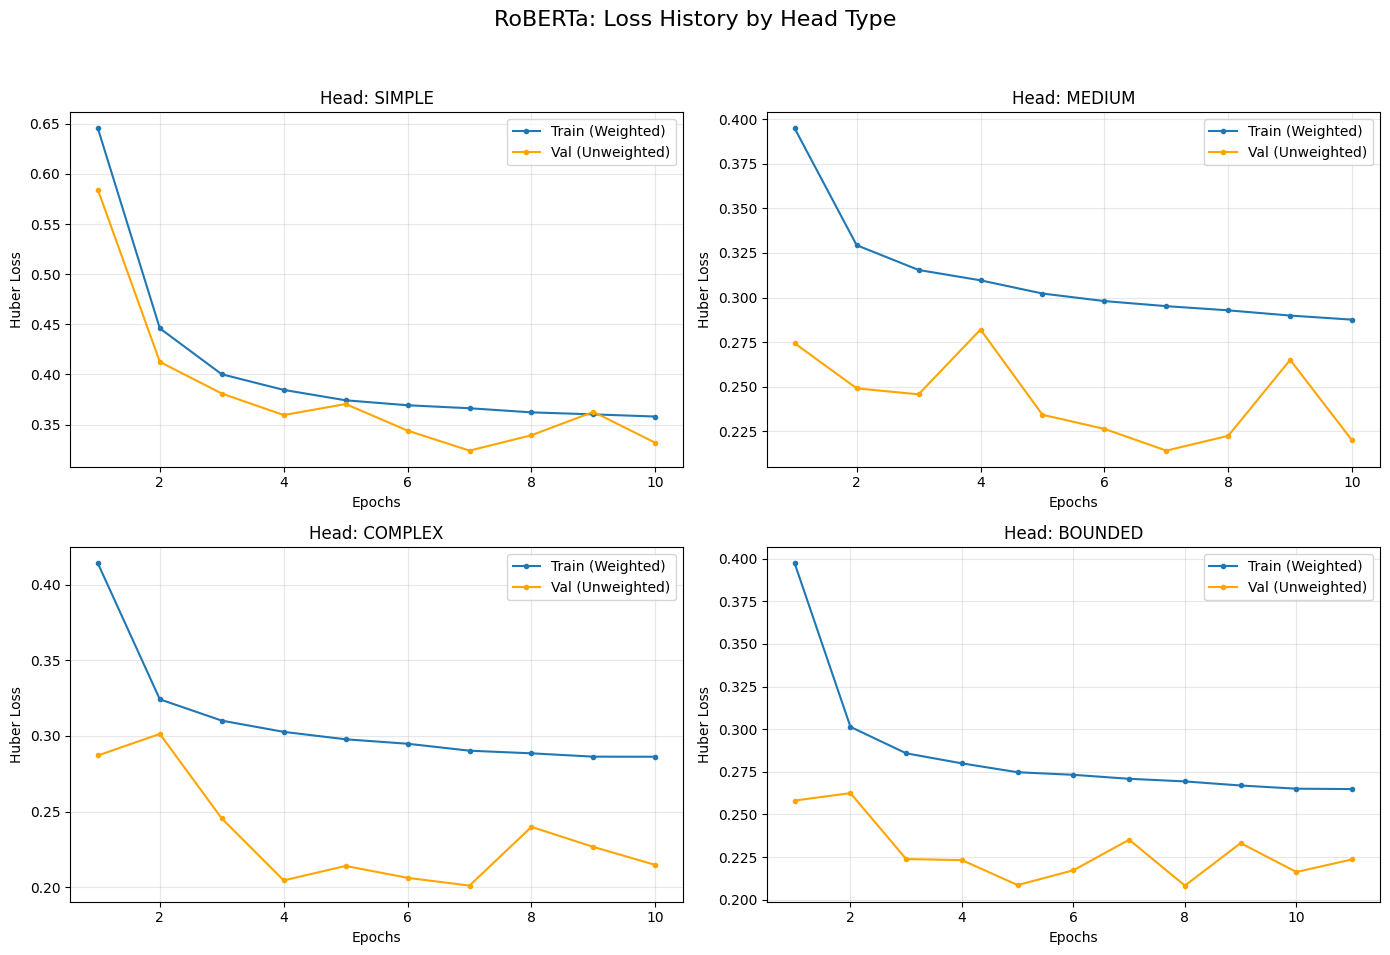


=== KẾT QUẢ ROBERTA ===
              MSE       MAE        R2  Best_Epoch
simple   0.724622  0.688791  0.606525         7.0
medium   0.495743  0.512866  0.730808         7.0
complex  0.476857  0.498058  0.741063         7.0
bounded  0.481760  0.502966  0.738401         8.0


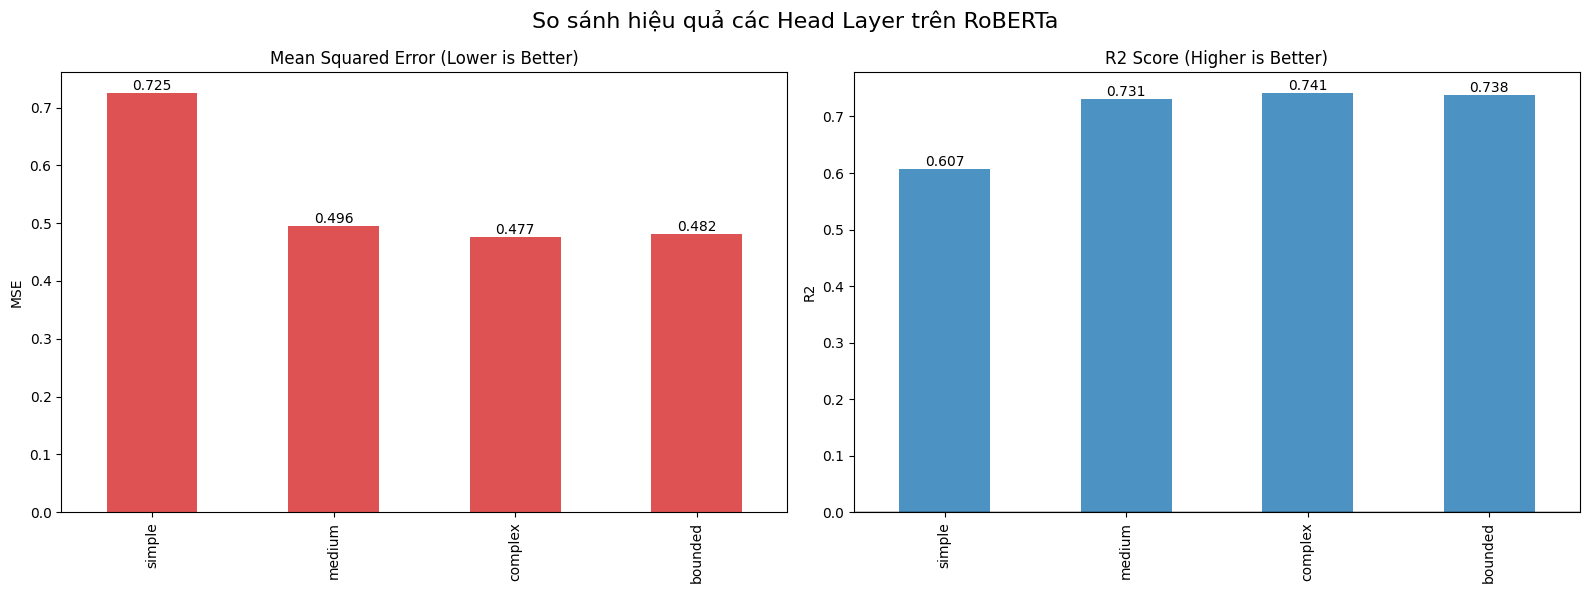

In [4]:
# 1. Vẽ biểu đồ Loss
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('RoBERTa: Loss History by Head Type', fontsize=16)
axes = axes.flatten()

for i, head in enumerate(head_types):
    ax = axes[i]
    t_loss = history[head]['train']
    v_loss = history[head]['val']
    epochs = range(1, len(t_loss) + 1)
    
    ax.plot(epochs, t_loss, label='Train (Weighted)', marker='.')
    ax.plot(epochs, v_loss, label='Val (Unweighted)', marker='.', color='orange')
    ax.set_title(f'Head: {head.upper()}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Huber Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Bảng so sánh chỉ số
df_res = pd.DataFrame(roberta_results).T
print("\n=== KẾT QUẢ ROBERTA ===")
print(df_res)

# 3. Vẽ biểu đồ so sánh Metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# MSE (Thấp là tốt)
df_res['MSE'].plot(kind='bar', ax=ax1, color='#d62728', alpha=0.8)
ax1.set_title('Mean Squared Error (Lower is Better)')
ax1.set_ylabel('MSE')
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f')

# R2 (Cao là tốt)
df_res['R2'].plot(kind='bar', ax=ax2, color='#1f77b4', alpha=0.8)
ax2.set_title('R2 Score (Higher is Better)')
ax2.set_ylabel('R2')
ax2.axhline(0, color='black', linewidth=1)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f')

plt.suptitle('So sánh hiệu quả các Head Layer trên RoBERTa', fontsize=16)
plt.tight_layout()
plt.show()

## DISTILLBERT

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel # <--- Thư viện DistilBERT
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Cấu hình thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. DATASET & CLASS WEIGHT ---
class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=128, is_train=False): 
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['clean_text', 'stars']).reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_train = is_train
        
        self.weights_map = {}
        if self.is_train:
            self.weights_map = self.calculate_weights()
            print(f"--> Class Weights map: {self.weights_map}")

    def calculate_weights(self):
        counts = self.df['stars'].value_counts().to_dict()
        total_samples = len(self.df)
        num_classes = len(counts)
        weights = {score: total_samples / (num_classes * count) for score, count in counts.items()}
        return weights

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.loc[index, 'clean_text'])
        score = float(self.df.loc[index, 'stars'])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        sample_weight = self.weights_map.get(score, 1.0) if self.is_train else 1.0

        return { 
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(score, dtype=torch.float),
            'weight': torch.tensor(sample_weight, dtype=torch.float)
        }

# --- 3. MODEL DISTILBERT (Concat 4 Layers) ---
class DistilBERTRegressor_head(nn.Module):
    def __init__(self, head_type='simple'):
        super(DistilBERTRegressor_head, self).__init__()
        
        # Load DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased', output_hidden_states=True)
        
        # Đóng băng (Freeze)
        for param in self.distilbert.parameters():
            param.requires_grad = False
            
        self.head_type = head_type
        
        # DistilBERT vẫn có hidden_size = 768
        # Concat 4 lớp cuối: 768 * 4 = 3072
        input_dim = 768 * 4 
        
        self.ln = nn.LayerNorm(input_dim)

        if head_type == 'simple':
            self.regressor = nn.Sequential(nn.Linear(input_dim, 1))
            
        elif head_type == 'medium':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.LayerNorm(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 1)
            )
            
        elif head_type == 'complex':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 1024),
                nn.LayerNorm(1024),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(1024, 256),
                nn.LayerNorm(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 1)
            )
            
        elif head_type == 'bounded':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid() 
            )

    def forward(self, input_ids, attention_mask):
        # DistilBERT trả về tuple, phần tử đầu là last_hidden_state
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        
        hidden_states = outputs.hidden_states
        
        # DistilBERT có 6 layers + 1 embedding.
        # Lấy token [CLS] (vị trí 0) từ 4 lớp cuối cùng (-1, -2, -3, -4)
        cls_embeddings = [hidden_states[i][:, 0, :] for i in [-1, -2, -3, -4]]
        
        embedding = torch.cat(cls_embeddings, dim=1) # (Batch, 3072)
        embedding = self.ln(embedding)
        
        out = self.regressor(embedding)

        if self.head_type == 'bounded':
            out = 1.0 + (out * 4.0)

        return out

# --- 4. HÀM EVALUATE & EARLY STOPPING ---
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions, real_values = [], []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device) 
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask) 
            predictions.extend(outputs.squeeze().tolist())
            real_values.extend(targets.tolist())
    
    mse = mean_squared_error(real_values, predictions)
    r2 = r2_score(real_values, predictions)
    return mse, r2

class EarlyStopping:
    def __init__(self, patience=3, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            torch.save(model.state_dict(), self.path)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience: self.early_stop = True
        else:
            self.best_score = score
            torch.save(model.state_dict(), self.path)
            self.counter = 0



Using device: cuda


--> Class Weights map: {5: 0.44982311700006433, 4: 0.7938475509393269, 3: 1.7657871480873628, 1: 1.8255955100176207, 2: 2.4805888090804293}
========== CHẠY THÍ NGHIỆM DISTILBERT ĐẦY ĐỦ ==========

>>> Training DistilBERT Head: SIMPLE...
  Epoch 1 | Train Loss: 0.4166 | Val Loss: 0.3846
  Epoch 2 | Train Loss: 0.3644 | Val Loss: 0.3803
  Epoch 3 | Train Loss: 0.3577 | Val Loss: 0.3756
  Epoch 4 | Train Loss: 0.3550 | Val Loss: 0.3908
  Epoch 5 | Train Loss: 0.3530 | Val Loss: 0.3614
  Epoch 6 | Train Loss: 0.3505 | Val Loss: 0.3647
  Epoch 7 | Train Loss: 0.3498 | Val Loss: 0.3528
  Epoch 8 | Train Loss: 0.3477 | Val Loss: 0.3453
  Epoch 9 | Train Loss: 0.3469 | Val Loss: 0.3487
  Epoch 10 | Train Loss: 0.3466 | Val Loss: 0.3786
  Epoch 11 | Train Loss: 0.3450 | Val Loss: 0.3435
  Epoch 12 | Train Loss: 0.3447 | Val Loss: 0.3608
  Epoch 13 | Train Loss: 0.3453 | Val Loss: 0.3418
  Epoch 14 | Train Loss: 0.3440 | Val Loss: 0.3427
  Epoch 15 | Train Loss: 0.3448 | Val Loss: 0.3419
  Epoch

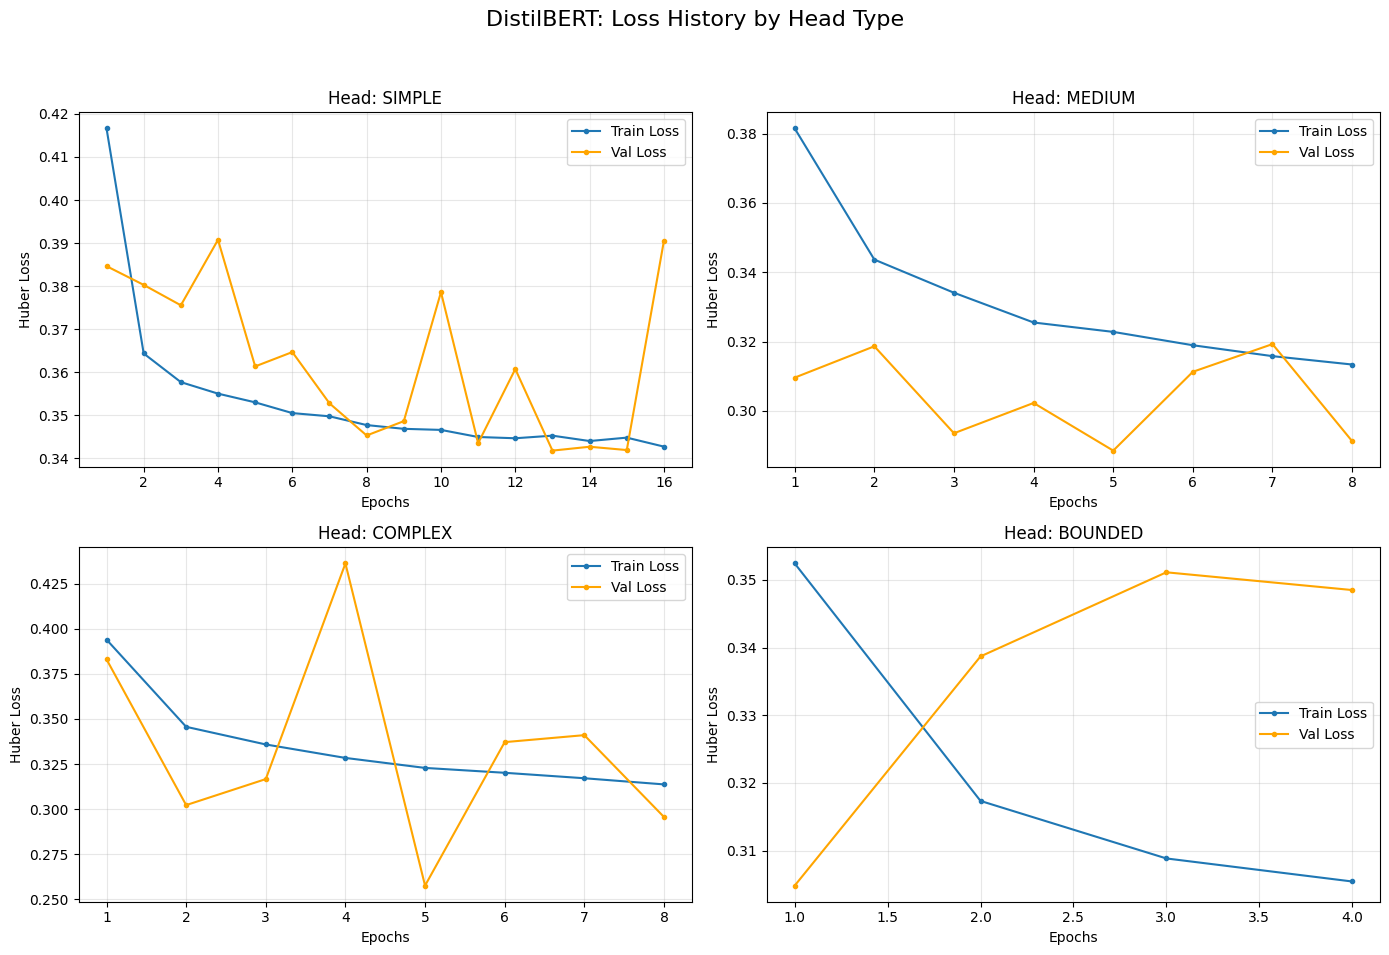


=== KẾT QUẢ TỔNG HỢP DISTILBERT ===
              MSE       MAE        R2  Best_Epoch
simple   0.787935  0.697284  0.572145        13.0
medium   0.680125  0.618286  0.630687         5.0
complex  0.639089  0.577943  0.652970         5.0
bounded  0.745010  0.637390  0.595454         1.0


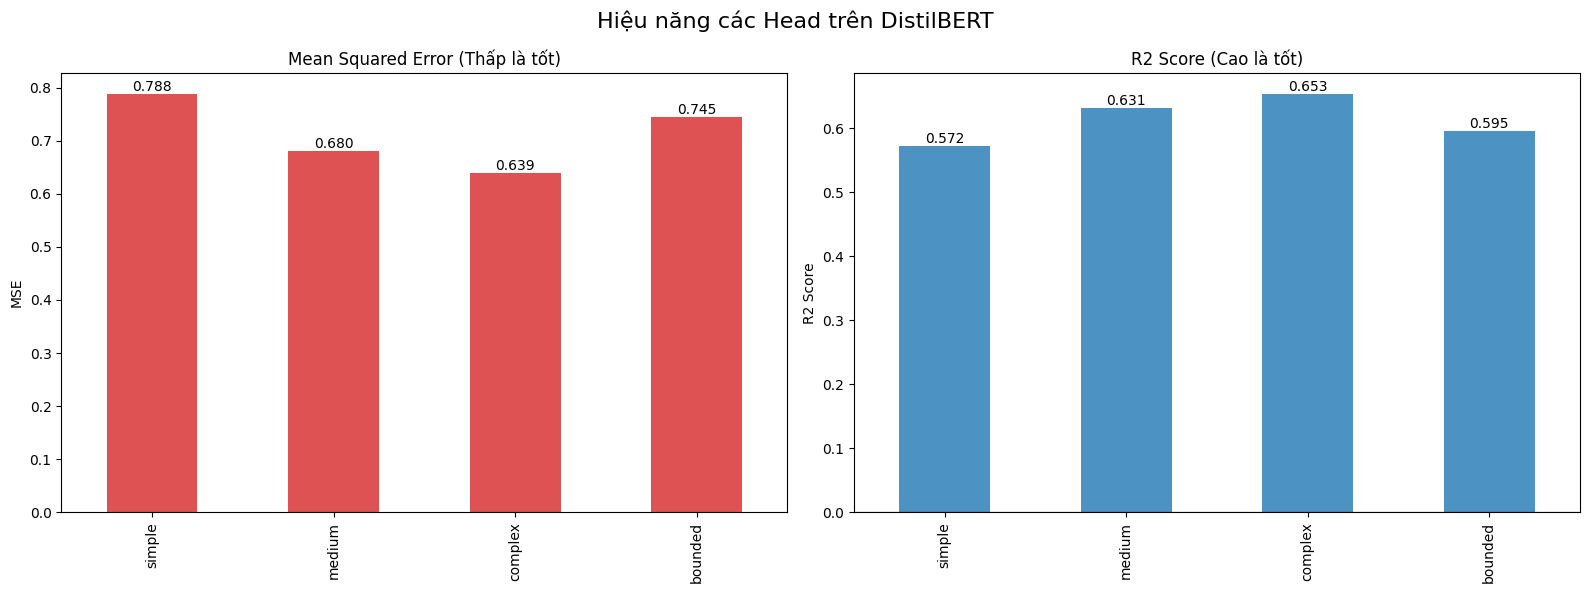

In [ ]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = ReviewDataset('trains.csv', tokenizer, is_train=True)
val_dataset = ReviewDataset('val.csv', tokenizer, is_train=False)
test_dataset = ReviewDataset('test.csv', tokenizer, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Cập nhật hàm Evaluate thêm MAE
def evaluate_model_full(model, data_loader, device):
    model.eval()
    predictions, real_values = [], []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device) 
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask) 
            predictions.extend(outputs.squeeze().tolist())
            real_values.extend(targets.tolist())
    
    mse = mean_squared_error(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions) # <--- Thêm MAE
    r2 = r2_score(real_values, predictions)
    return mse, mae, r2

# --- TRAINING LOOP ---
head_types = ['simple', 'medium', 'complex', 'bounded']
distil_results = {}
history = {} # <--- Biến lưu lịch sử Loss để vẽ biểu đồ
EPOCHS = 20
PATIENCE = 3

print(f"{'='*10} CHẠY THÍ NGHIỆM DISTILBERT ĐẦY ĐỦ {'='*10}")

for head in head_types:
    print(f"\n>>> Training DistilBERT Head: {head.upper()}...")
    model = DistilBERTRegressor_head(head_type=head).to(device)
    
    # Dùng HuberLoss + Class Weight (Manual reduction)
    criterion = nn.HuberLoss(delta=1.0, reduction='none')
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=1e-4)
    
    save_path = f'distil_{head}_best.pt'
    early_stopping = EarlyStopping(patience=PATIENCE, path=save_path)
    
    train_losses_history = []
    val_losses_history = []
    
    for epoch in range(EPOCHS):
        # --- TRAIN ---
        model.train()
        batch_losses = []
        for d in train_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            weights = d["weight"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = (criterion(outputs.squeeze(), targets) * weights).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        avg_train_loss = np.mean(batch_losses)
        train_losses_history.append(avg_train_loss) # Lưu history
        
        # --- VAL ---
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                # Val không nhân weight
                val_loss = criterion(outputs.squeeze(), targets).mean()
                val_batch_losses.append(val_loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses_history.append(avg_val_loss) # Lưu history
        
        print(f"  Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("  ==> Early Stopping!")
            break
    
    # Lưu lại lịch sử của Head này
    history[head] = {
        'train': train_losses_history,
        'val': val_losses_history
    }
            
    # --- TEST ---
    model.load_state_dict(torch.load(save_path))
    mse, mae, r2 = evaluate_model_full(model, test_loader, device)
    
    distil_results[head] = {
        'MSE': mse, 
        'MAE': mae, 
        'R2': r2,
        'Best_Epoch': epoch - PATIENCE + 1
    }
    print(f"  => Kết quả {head}: R2={r2:.4f}, MSE={mse:.4f}")

# --- VẼ BIỂU ĐỒ (VISUALIZATION) ---

# 1. Biểu đồ Loss (Train vs Val)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('DistilBERT: Loss History by Head Type', fontsize=16)
axes = axes.flatten()

for i, head in enumerate(head_types):
    ax = axes[i]
    t_loss = history[head]['train']
    v_loss = history[head]['val']
    epochs_range = range(1, len(t_loss) + 1)
    
    ax.plot(epochs_range, t_loss, label='Train Loss', marker='.')
    ax.plot(epochs_range, v_loss, label='Val Loss', marker='.', color='orange')
    ax.set_title(f'Head: {head.upper()}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Huber Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Biểu đồ so sánh Metrics
df_res = pd.DataFrame(distil_results).T
print("\n=== KẾT QUẢ TỔNG HỢP DISTILBERT ===")
print(df_res)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# MSE
df_res['MSE'].plot(kind='bar', ax=ax1, color='#d62728', alpha=0.8)
ax1.set_title('Mean Squared Error (Thấp là tốt)')
ax1.set_ylabel('MSE')
for c in ax1.containers: ax1.bar_label(c, fmt='%.3f')

# R2
df_res['R2'].plot(kind='bar', ax=ax2, color='#1f77b4', alpha=0.8)
ax2.set_title('R2 Score (Cao là tốt)')
ax2.set_ylabel('R2 Score')
ax2.axhline(0, color='black', linewidth=0.8)
for c in ax2.containers: ax2.bar_label(c, fmt='%.3f')

plt.suptitle('Hiệu năng các Head trên DistilBERT', fontsize=16)
plt.tight_layout()
plt.show()